## Deep Hedging with Signature Transformer

Deep hedging is a new approach in hedging, moving away from traditional methods (using Greeks or statistical hedging). See more in [this link](http://www.deephedging.com/).

The following script demonstrates a result from the paper ["Sigformer: Signature Transformers for Deep Hedging"]() that puts attentions over signature terms. 

Overview of the architecture can be illustrated in this figure

![SigFormer](https://github.com/anh-tong/signax/blob/main/assets/sigformer.jpg)

Note that this example is quite advanced and technical. For detailed descriptions, please see the paper.

In [1]:
from functools import partial

from typing import Dict, Callable, Tuple, List
import equinox as eqx
from jaxtyping import Array, Float
import jax.random as jrandom
import jax.numpy as jnp
import jax
import numpy as np

# backbone signature transform
from sigformer import SigFormer, Config

from rbergomi import BaseDerivative, RoughBergomiStock, EuropeanOption

from tqdm import tqdm
import optax

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def pl(
    spot: Float[Array, "n_steps dim"],
    unit: Float[Array, "n_steps dim"],
    payoff: Float = None,
):
    """
    Use `jax.vmap` when working with with multiple paths
    """
    assert spot.shape == unit.shape

    output = unit[:-1] * jnp.diff(spot, axis=0)
    output = jnp.sum(output)

    if payoff is not None:
        output = output - payoff

    return output

Let us define a base class for deep hedging

In [3]:
class BaseHedger(eqx.Module):
    derivative: BaseDerivative

    def compute_hedge(
        self,
        simulated_data: Dict[str, Float[Array, "n_paths n_steps"]],
        *,
        key: jrandom.PRNGKey,
    ) -> Float[Array, "n_paths dim n_steps"]:
        """Given `simulated_data`, this returns how many units should trade"""
        raise NotImplementedError

    def get_prices(
        self, simulated_data: Dict[str, Float[Array, "n_paths n_steps"]]
    ) -> Float[Array, "n_paths dim n_steps"]:
        """Get prices of tradable assets"""
        raise NotImplementedError

    def compute_pnl(
        self,
        rng_key: jrandom.PRNGKey,
        n_paths: int,
        simulated_data: Dict[str, Float[Array, "n_paths n_steps"]] = None,
        init_state=None,
        return_portfolio_and_payoff=False,
    ):
        """Compute Profit-N-Loss"""

        if rng_key is None:
            hedge_key = None
        else:
            rng_key, hedge_key = jrandom.split(rng_key)
        if simulated_data is None:
            rng_key = jrandom.split(rng_key, n_paths)
            simulated_data = jax.vmap(
                partial(self.derivative.simulate, init_state=init_state)
            )(rng_key)
        prices = self.get_prices(simulated_data)
        unit = self.compute_hedge(simulated_data, key=hedge_key)
        payoff = self.derivative.payoff(simulated_data["spot"])

        if return_portfolio_and_payoff:
            portfolio = jax.vmap(pl)(spot=prices, unit=unit)
            return portfolio, payoff
        else:
            return jax.vmap(pl)(spot=prices, unit=unit, payoff=payoff)

In [4]:
class QuadraticLoss:
    p0: float

    def __init__(self, p0):
        self.p0 = p0

    def __call__(self, input, target):
        return jnp.mean(jnp.square(input - target + self.p0))

This is the main class for deep hedging with SigFormer backbone

In [5]:
class SigHedger(BaseHedger):
    model: eqx.Module
    config: Config = eqx.static_field()
    criterion: QuadraticLoss = eqx.static_field()
    derivative: BaseDerivative = eqx.static_field()

    n_inputs: int = eqx.static_field()
    n_outputs: int = eqx.static_field()

    def __init__(
        self,
        derivative,
        criterion,
        signature_depth=3,
        model_dim=2,
        n_attn_heads=1,
        n_attn_blocks=2,
        d_ff=12,
        dropout=0.1,
        *,
        key: jrandom.PRNGKey,
    ) -> None:
        self.derivative = derivative
        self.criterion = criterion
        # inputs consist of log-moneyness and volatility
        self.n_inputs = 2
        # output the hedge for spot and forward variance
        self.n_outputs = 2
        self.config = Config(
            in_dim=self.n_inputs,
            out_dim=self.n_outputs,
            dim=model_dim,
            num_heads=n_attn_heads,
            d_ff=d_ff,
            dropout=dropout,
            n_attn_blocks=n_attn_blocks,
            order=signature_depth,
        )
        self.model = self.initialize_model(key=key)

    def initialize_model(self, key: jrandom.PRNGKey) -> Callable[[Array], Array]:
        model = SigFormer(config=self.config, key=key)
        return model

    def compute_hedge(
        self,
        simulated_data: Dict[str, Array],
        *,
        key: jrandom.PRNGKey = None,
    ):
        def _compute_hedge(single_path):
            # inputs consist of log-moneyness and volatility
            logmoneyness = single_path["spot"] / self.derivative.strike
            volatility = self.derivative.underlier.volatility(**single_path)
            # now gather log-moneyness and volatility
            input = jnp.stack([logmoneyness, volatility], axis=-1)
            output = self.model(input, key=key)

            return output

        return jax.vmap(_compute_hedge)(simulated_data)

    def __call__(
        self,
        input: Float[Array, "n_steps n_features"],
    ) -> Float[Array, "n_steps n_hedges"]:
        return self.model(input)

    def get_prices(
        self, simulated_data: Dict[str, Float[Array, "n_paths n_steps"]]
    ) -> Float[Array, "n_path n_steps dim"]:
        """Get the prices of tradable assets"""
        spot = simulated_data["spot"]
        forward_variance = simulated_data["forward_variance"]
        return jnp.stack([spot, forward_variance], axis=-1)

    def compute_loss(
        self,
        init_state,
        n_paths=1000,
        n_times=1,
        p0=None,
        *,
        rng_key: jrandom.PRNGKey,
    ) -> Float:
        def _portfolio_and_payoff(key):
            return self.compute_pnl(
                rng_key=key,
                n_paths=n_paths,
                init_state=init_state,
                return_portfolio_and_payoff=True,
            )

        def _compute_loss(key):
            portfolio, payoff = _portfolio_and_payoff(key)
            payoff = payoff if p0 is None else p0
            return self.criterion(portfolio, payoff)

        if n_times == 1:
            return _compute_loss(rng_key)
        else:
            batch_compute_loss = jax.vmap(_compute_loss)
            rng_key = jrandom.split(rng_key, n_times)
            return jnp.mean(batch_compute_loss(rng_key), axis=0)

The following class computes the perfect hedge for rough Bergomi models. The implementation is based on [Deep Hedging under Rough Volatility](https://arxiv.org/abs/2102.01962)

In [6]:
class RBergomiDeltaHedger(BaseHedger):
    underlier: RoughBergomiStock
    n_paths: int
    batch_size: int = 1000

    def __init__(self, derivative: BaseDerivative, n_paths=1000):
        self.derivative = derivative
        self.underlier = derivative.underlier
        assert isinstance(self.underlier, RoughBergomiStock)
        self.n_paths = n_paths

    def compute_hedge(
        self,
        simulated_data: Dict[str, Float[Array, "n_paths n_steps"]],
        *,
        key: jrandom.PRNGKey,
    ) -> Float[Array, "n_paths n_steps dim"]:
        spot = simulated_data["spot"]
        variance = simulated_data["variance"]
        forward_variance = simulated_data["forward_variance"]

        forward_offset_steps = self.underlier.forward_offset_steps

        def compute_delta_for_a_point(
            spot, variance, forward_variance, remaining_steps_spot, key
        ):
            return self._delta(
                spot=spot,
                variance=variance,
                forward_variance=forward_variance,
                remaining_steps_spot=remaining_steps_spot,
                remaining_steps_variance=remaining_steps_spot + forward_offset_steps,
                n_paths=self.n_paths,
                rng_key=key,
            )

        @partial(jax.jit, static_argnames="remaining_steps_spot")
        def compute_delta_for_path(
            spot, variance, forward_variance, remaining_steps_spot, key
        ):
            n_paths = spot.shape[0]
            key = jrandom.split(key, n_paths)
            fn = partial(
                compute_delta_for_a_point, remaining_steps_spot=remaining_steps_spot
            )
            return jax.vmap(fn)(
                spot=spot, variance=variance, forward_variance=forward_variance, key=key
            )

        delta_prices, delta_variances = [], []
        for i in tqdm(range(spot.shape[-1] - 1)):
            delta_price, delta_variance = compute_delta_for_path(
                spot=spot[..., i],
                variance=variance[..., i],
                forward_variance=forward_variance[..., i:],
                remaining_steps_spot=spot.shape[-1] - i,
                key=jrandom.fold_in(key, i),
            )

            delta_prices.append(delta_price)
            delta_variances.append(delta_variance)

        delta_prices = jnp.stack(delta_prices, axis=-1)
        delta_variances = jnp.stack(delta_variances, axis=-1)

        delta = jnp.stack([delta_prices, delta_variances], axis=-1)
        delta = jnp.pad(delta, ((0, 0), (0, 1), (0, 0)), constant_values=0.0)

        return delta

    def _delta(
        self,
        spot: Float,
        variance: Float,
        forward_variance: Float[Array, " remaining_steps"],
        remaining_steps_spot: int,
        remaining_steps_variance: int,
        n_paths: int,
        *,
        rng_key: jrandom.PRNGKey,
    ) -> Tuple[Float, Float]:
        """
        This follows Sect. 3.2 of "Deep hedging under Rough Volatity" paper.

        However, the most detailed description is in
        "A Martingale Approach for Fractional Brownian Motions and Related Path Dependent PDEs"

        """
        hurst = self.underlier.hurst

        # `a` is the directional for Gateaux derivative
        a = remaining_steps_variance - jnp.arange(0, remaining_steps_spot)
        a = a * self.underlier.dt
        a = a ** (hurst - 0.5)

        # obtain \\Theta_t back from `forward_variance`
        T_forward = (
            self.derivative.n_steps + self.underlier.forward_offset_steps
        ) * self.underlier.dt
        t = self.derivative.maturity - remaining_steps_spot * self.underlier.dt
        term = (T_forward - t) ** (2 * hurst) - T_forward ** (2 * hurst)
        theta = (
            jnp.log(forward_variance / variance) - 0.5 * self.underlier.eta**2 * term
        )

        def _compute_payoff(s0, eps, key):
            theta_eps = eps * a + theta
            output = self.underlier.simulate(
                rng_key=key,
                n_steps=remaining_steps_spot,
                init_state=(s0, variance, theta_eps),
            )
            spot = output["spot"]
            # compute payoff
            payoff = self.derivative.payoff(spot=spot)

            return payoff

        def _fun(s0, eps, key):
            """return mean of payoff"""
            key = jrandom.split(key, n_paths)
            payoff = jax.vmap(lambda k: _compute_payoff(s0, eps, k))(key)
            return jnp.mean(payoff)

        # compute two derivatives like in Eq. 3.7
        # note that we approximate Gateaux derivatives by sending \\epsilon to 0
        # also, we use auto-diff instead of finite diference
        grad = jax.grad(_fun, argnums=(0, 1))(spot, jnp.asarray(0.0), key=rng_key)
        delta_price, directional_grad = grad

        # this is the second term in Eq. 3.7
        time_to_maturity = remaining_steps_variance * self.underlier.dt
        delta_variance = (
            time_to_maturity ** (-self.underlier.hurst + 0.5)
            * directional_grad
            / forward_variance[0]
        )

        return delta_price, delta_variance

    def get_prices(self, simulated_data: Dict[str, Array]) -> Array:
        spot = simulated_data["spot"]
        forward_variance = simulated_data["forward_variance"]
        return jnp.stack([spot, forward_variance], axis=-1)

### Set up parameters


In [7]:
# rough Bergomi price model
hurst = 0.1
rho = -0.7
eta = 1.9
xi = 0.235**2
cost = 0.0
dt = 1.0 / 356
forward_offset = 15.0 / 356

# derivative
T = 30.0 / 356  # maturity
S0 = 100.0  # initial price
K = 100.0  # strike

# SigHedger
model_dim = 3
n_attn_heads = 12
n_attn_blocks = 5

# training
n_train_paths = 1000
n_valid_paths = 1000
n_epochs = 5000
lr = 1e-4

# testing
n_test_paths = 5_000

# a fixed random seed
seed = 123

In [8]:
# JAX-based PRNG random
key = jrandom.PRNGKey(seed)
model_key, train_key, p0_key, test_key = jrandom.split(key, 4)

We consider the underlying stock as rough Bergomi and the derivative as European option

In [9]:
stock = RoughBergomiStock(
    hurst=hurst,
    rho=rho,
    xi=xi,
    cost=cost,
    dt=dt,
    forward_offset=forward_offset,
)
init_state = (S0, stock.xi, None)

derivative = EuropeanOption(
    underlier=stock,
    call=True,
    strike=K,
    maturity=T,
)

### Perfect hedge

We compute the perfect hedge given the above implementation

In [10]:
delta_hedger = RBergomiDeltaHedger(derivative=derivative)

In [11]:
delta_pl = delta_hedger.compute_pnl(
    rng_key=test_key,
    n_paths=n_test_paths,
    init_state=init_state,
)

100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


<BarContainer object of 50 artists>

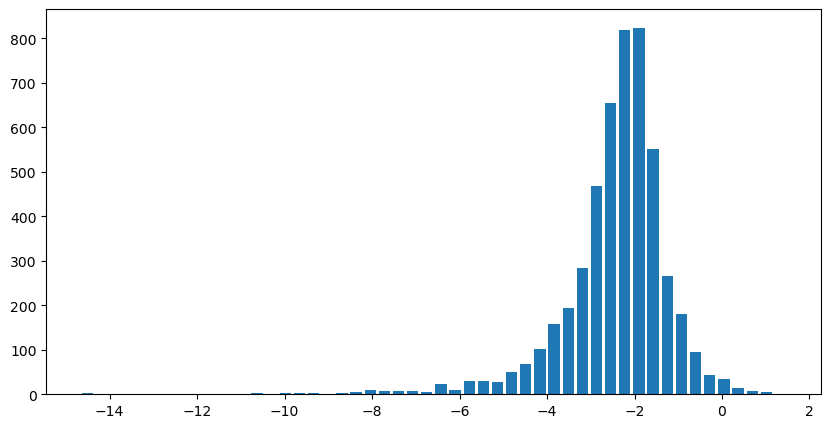

In [12]:
hist, bins = np.histogram(delta_pl, bins=50, density=False)
plt.figure(figsize=(10, 5))
plt.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.8)

### Deep hedge with SigFormer

Now, we use Sigformer as the main backbone for the deep hedge model

In [13]:
# obtain p0 from expectation of payoff
payoff_fn = lambda key: derivative.payoff(rng_key=key, init_state=init_state)
payoff = jax.vmap(payoff_fn)(jrandom.split(p0_key, n_test_paths))
p0 = jnp.mean(payoff)
print(f"p0={p0.item():.2f}")

p0=2.44


In [14]:
criterion = QuadraticLoss(p0=p0)

model = SigHedger(
    derivative=derivative,
    criterion=criterion,
    key=model_key,
)

In [15]:
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

The standard equinox training step can be implemented as

In [16]:
@eqx.filter_value_and_grad
def compute_loss(model: SigHedger, n_simulate_paths, rng_key):
    return model.compute_loss(
        init_state=init_state,
        n_paths=n_simulate_paths,
        rng_key=rng_key,
    )

In [17]:
@eqx.filter_jit
def make_step(model: SigHedger, opt_state, n_simulate_paths, rng_key):
    loss_value, grads = compute_loss(model, n_simulate_paths, rng_key)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

Now we're ready for the training part

In [18]:
progress = tqdm(range(n_epochs), desc="Train")
for i in progress:
    model, opt_state, loss_value = make_step(
        model,
        opt_state,
        n_simulate_paths=n_train_paths,
        rng_key=jrandom.fold_in(train_key, i),
    )

Train:   0%|          | 0/5000 [00:00<?, ?it/s]

Train: 100%|██████████| 5000/5000 [01:29<00:00, 56.07it/s]


The profit-and-loss for Sigformer is computed as

In [19]:
eval_model = eqx.tree_inference(model, True)
sig_pl = eval_model.compute_pnl(
    rng_key=test_key, n_paths=n_test_paths, init_state=init_state
)

A utility function to compare between two methods

In [20]:
def plot_histogram(arrs, names, bins=30, stat="probability", **fig_kwargs):
    dfs = [
        pd.DataFrame.from_dict({"PnL": value, "model": name})
        for value, name in zip(arrs, names)
    ]
    df = pd.concat(axis=0, ignore_index=True, objs=dfs)

    fig, ax = plt.subplots(**fig_kwargs)
    sns.histplot(
        data=df,
        x="PnL",
        hue="model",
        ax=ax,
        multiple="dodge",
        stat=stat,
        bins=bins,
    )

    return fig

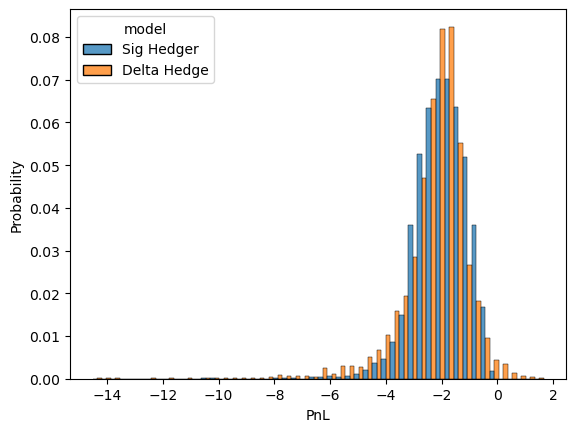

In [21]:
fig = plot_histogram([sig_pl, delta_pl], ["Sig Hedger", "Delta Hedge"], bins=50)

We can see deep hedging with SigFormer can give similar PnL performance compared to perfect delta hedging